### Import packages

In [47]:
from astropy.coordinates import SkyCoord
import numpy as np
from astropy import wcs
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy import units as u  
from astropy.modeling import models, fitting

### Import major and minor axis 

In [48]:
sources=[16,29,33,38,45]
lmajax=[]
lminax=[]
for source in sources:
    file2dfit='/home/juan/Desktop/Research/Data2.0/2DFit/'+str(source)+'/2DGssfit'+str(source)+'Log.txt'
    file1=open(file2dfit,'r')
    i=1
    for line in file1:
        if i==27:
            line1=line
        if i==28:
            line2=line
        i+=1
    file1.close()
    for j in range(len(line1)):
        if line1[j]==':':
            k=j+1
            majorax=''
            while line1[k]!='+':
                majorax+=line1[k]
                k+=1
    for j in range(len(line2)):
        if line2[j]==':':
            k=j+1
            minorax=''
            while line2[k]!='+':
                minorax+=line2[k]
                k+=1
    lmajax.append(float(majorax.strip()))
    lminax.append(float(minorax.strip()))

### Calculate "r" by averaging major and minor axes and dividing by two

In [49]:
lradii=[]
for i in range(len(lmajax)):
    avg=(lmajax[i]+lminax[i])/2
    lradii.append(avg/2)

### Convert distance to meters (?) using small angle approximation

In [50]:
lrad=[]
for i in range(len(lradii)):
    lrad.append((lradii[i]*436*3.085*10**16)/206265.0)

## Obtain velocity range from gaussian fitting (3-sigma or 50% (?))

### Obtain source spectra

In [51]:
filename_gas=fits.open('/home/juan/Desktop/Research/Data2.0/Serpens/Serpens_Feather_c18o.fits')

### 3-sigma line

In [52]:
mom0_rms=np.mean(filename_gas[0].data[:,689:719,939:977].std())
levs_3=3*mom0_rms

### Source coordinates

In [53]:
filenametxt='/home/juan/Desktop/Research/Data/sourcecoordinates.txt'
ra,dec = np.loadtxt(filenametxt,unpack=True,usecols=(0,1),dtype='S')
coord=SkyCoord(ra,dec,frame='icrs',unit=(u.hourangle,u.deg))

### Convert degrees to pixels

In [54]:
filename='/home/juan/Desktop/Research/Data2.0/moment_0_New_feather.fits'
Pixlist=[]
hdulist = fits.open(filename)
w=wcs.WCS(hdulist[0].header)
for i in range(len(coord)):
	arr=np.array([[coord.ra[i].value,coord.dec[i].value]])
	xpix,ypix=w.all_world2pix(arr,0)[0]
	Pixlist.append((xpix,ypix))

### Previous info.

In [55]:
lsource=[16,29,33,38,45]
lmean_guess=[7.0,8.0,7.5,7.0,7.5]
chan=72

### Previous info. setup

In [56]:
hdu=filename_gas
vo=hdu[0].header['CRVAL3']/1000
deltv=hdu[0].header['CDELT3']/1000
vc=8.0*u.km/u.s

### Create spectra arrays

In [57]:
lspectra=[]
for i in range(len(lsource)):
    xpix=int(round(Pixlist[lsource[i]-1][0]))
    ypix=int(round(Pixlist[lsource[i]-1][1]))
    velarray=vo+np.arange(chan)*deltv
    intarray=np.mean(hdu[0].data[:,ypix-2:ypix+2,xpix-2:xpix+2],axis=(1,2))
    lspectra.append([velarray,intarray])

### Gaussian fitting and values at FWHM (maybe use a wider range so you don't exlude too many channels. 2.5-sigma?)

### https://en.wikipedia.org/wiki/Full_width_at_half_maximum

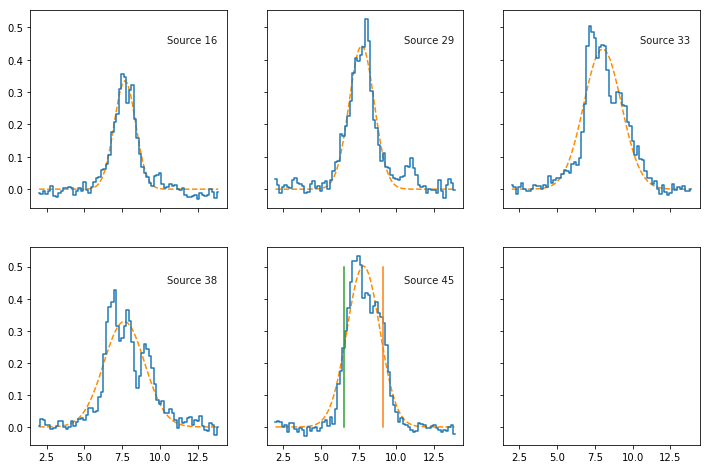

In [58]:
velrange=[]
fit_g=fitting.LevMarLSQFitter()
fitinfo=[] #amplitude, mean, std
f, li = plt.subplots(2, 3, sharex='col', sharey='row',figsize=(12,8))
i=0
for j in range(2):
    for k in range(3):
        if i<len(lsource):
            g2_init = models.Gaussian1D(amplitude=lspectra[i][1].max(), mean=lmean_guess[i], stddev=0.5)
            g2=fit_g(g2_init,lspectra[i][0],lspectra[i][1])
            #plt.plot(lspectra[i][0], g2(lspectra[i][0]),color='darkorange',linestyle='--')
            #plt.plot(lspectra[i][0],lspectra[i][1],drawstyle='steps-mid')
            fitinfo.append([g2.amplitude.value,g2.mean.value,g2.stddev.value])
            velrange.append(np.round(2.355*g2.stddev.value,2))
            li[j,k].plot(lspectra[i][0], g2(lspectra[i][0]),color='darkorange',linestyle='--')
            li[j,k].plot(lspectra[i][0],lspectra[i][1],drawstyle='steps-mid')
            li[j,k].text(10.5,0.45,'Source '+str(lsource[i]),color='0.1')
            li[j,k].plot(np.repeat((2.355/2)*g2.stddev.value+g2.mean.value,len(np.arange(0,g2.amplitude.value,0.5))),np.arange(0,g2.amplitude.value,0.5),drawstyle='steps-mid')
            li[j,k].plot(np.repeat(-(2.355/2)*g2.stddev.value+g2.mean.value,len(np.arange(0,g2.amplitude.value,0.5))),np.arange(0,g2.amplitude.value,0.5),drawstyle='steps-mid')
            i+=1

In [59]:
velrange

[1.67, 1.95, 2.93, 3.19, 2.56]

### Calculate masses in solar mass units: Check and add units to all quantities

In [66]:
lmass=[]
G=6.674e-11
M=1*u.Msun.to(u.kg)
for i in range(len(lsource)):
    lmass.append(lrad[i]*(velrange[i]*1000/2)**2/(G*M))

In [67]:
lmass

[0.674572069517138,
 1.360457106897034,
 3.2666022186360166,
 2.71294399191996,
 1.4177151603995852]

### Dust mass

In [62]:
filenametxt='/home/juan/Desktop/Research/Data2.0/DustMass.txt'

In [63]:
dustmass= np.loadtxt(filenametxt,unpack=True,usecols=(0),dtype='S')

In [68]:
gdratio=[]
t=0
for i in lsource:
    gdratio.append(lmass[t]/float(dustmass[i-1]))
    t+=1

In [69]:
gdratio

[4.527329325618376,
 38.870203054200964,
 12.420540755270025,
 40.4917013719397,
 1.6639849300464615]